<a href="https://colab.research.google.com/github/yj2811/Yoga-Pose-Classification/blob/main/Yoga_Pose_Classifier_CNN_kerastuner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install keras-tuner

     |████████████████████████████████| 96 kB 2.4 MB/s 
  Created wheel for kt-legacy: filename=kt_legacy-1.0.3-py3-none-any.whl size=9568 sha256=1f596ed8fa3f50147293ff18249619172b8e2a50ffe3e11cc878b34d65d4bf8a
  Stored in directory: /root/.cache/pip/wheels/38/5c/e0/13003e68c17f403af40b92a24d20171b95fef13b0fdaba833c
Successfully built kt-legacy


In [2]:
# !pip install tensorflow-gpu

     |████████████████████████████████| 454.3 MB 17 kB/s 


In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt


In [3]:
# Setting the global random seed
seed = 1234
tf.random.set_seed(seed)
np.random.seed(seed)

In [4]:
# Import dataset from google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
train_path = '/content/drive/MyDrive/evolv-fit/yoga pose/Train/'
test_path = '/content/drive/MyDrive/evolv-fit/yoga pose/Test/'

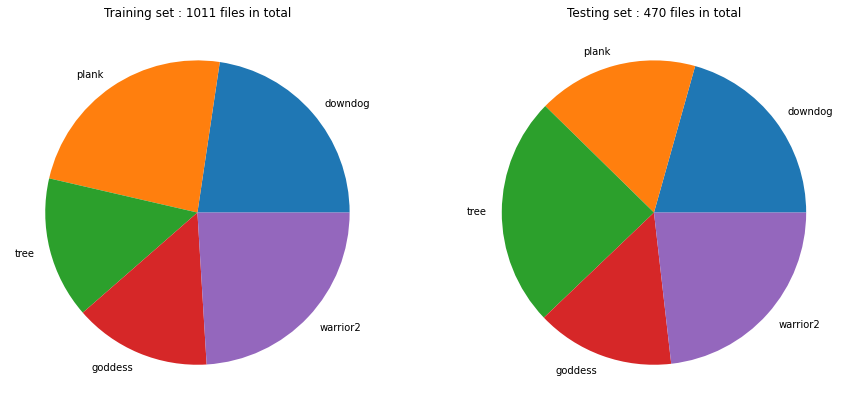

In [6]:
# Visualising the distribution of data

# train_distribution and test_distribution will have the number of files in a particular folder (directory)
train_distribution = []
test_distribution = []

# names_classes will have the folder names (different types of yoga poses) appended to it
names_classes = []

# Train
for dir in os.listdir(train_path):
    names_classes.append(dir) 
    n1 = len(os.listdir(train_path+dir+'/')) 
    train_distribution.append(n1) 
    
# Test
for dir in os.listdir(test_path):
   
    n2 = len(os.listdir(test_path+dir+'/')) 
    test_distribution.append(n2) 

# Using pie chart to show distribution
plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
plt.pie(train_distribution, labels=names_classes)
plt.title(f'Training set : {sum(train_distribution)} files in total')

plt.subplot(1,2,2)
plt.pie(test_distribution, labels=names_classes)
plt.title(f'Testing set : {sum(test_distribution)} files in total')

plt.show()

In [7]:
# Data augmentation

# Using 25% of the Testing set instead of the Training set for Validation data
# Augmenting the data to generate more images

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Summarising all data augmentation techniques in one object call (data generator object) 
train_dataGenerator = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range = 0.2, 
    zoom_range = 0.2, 
    rescale = 1/255, 
    horizontal_flip = True 
)

test_dataGenerator = ImageDataGenerator(
    rescale = 1/ 255,
    horizontal_flip = True,
    # Data for validation
    validation_split=0.25, 
)

In [8]:
# Loading and generating batches of randomly transformed images
# Categorical class mode due to multiple classes
train_generated = train_dataGenerator.flow_from_directory(
    train_path, 
    batch_size = 16,
    class_mode = 'categorical',
    target_size = (128, 128), 
    shuffle = True,
    seed = 1234
)

val_generated = test_dataGenerator.flow_from_directory(
    test_path, 
    batch_size = 16,
    class_mode = 'categorical', 
    target_size = (128,128), 
    shuffle = True,
    seed = 1234,
    subset='validation',
)


test_generated = test_dataGenerator.flow_from_directory(
    test_path, 
    batch_size = 16,
    class_mode = 'categorical', 
    target_size = (128,128), 
    shuffle = True,
    seed = 1234,
    subset='training', 
)


# train_generated, val_generated and test_generated are image directory iterators capable of reading images from a directory on disk.

Found 1006 images belonging to 5 classes.
Found 116 images belonging to 5 classes.
Found 354 images belonging to 5 classes.


In [9]:
!nvidia-smi

Thu Jul 22 12:46:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
from tensorflow.keras import Sequential, layers

num_classes = len(names_classes)

image_size = 128

def build_model(hp):
  model = Sequential([
      layers.Conv2D(
          filters=hp.Int('conv_1_filter', min_value=8, max_value=128, step=16),
          kernel_size=hp.Choice('conv_1_kernel', values=[3,5]),
          padding='same',
          activation='relu',
          input_shape=(image_size, image_size, 3)
      ),

      layers.MaxPooling2D(),
      
      layers.Conv2D(
          filters=hp.Int('conv_2_filter', min_value=16, max_value=128, step=16),
          kernel_size=hp.Choice('conv_2_kernel', values=[3,5]),
          padding='same',
          activation='relu',
      ),

      layers.MaxPooling2D(),

      layers.Conv2D(
          filters=hp.Int('conv_3_filter', min_value=32, max_value=128, step=16),
          kernel_size=hp.Choice('conv_3_kernel', values=[3,5]),
          padding='same',
          activation='relu',
      ),

      layers.MaxPooling2D(),

      layers.Flatten(),

      layers.Dense(
          units=hp.Int('dense_1_units', min_value = 224, max_value = 288, step=16),
          activation='relu'
      ),

      layers.Dropout(
                rate=hp.Float(
                    'dropout_1',
                    min_value=0.0,
                    max_value=0.5,
                    default=0.25,
                    step=0.05
                )
      ),

      layers.Dense(
          units=hp.Int('dense_2_units', min_value = 224, max_value = 288, step=16),
          activation='relu'
      ),

      layers.Dropout(
                rate=hp.Float(
                    'dropout_2',
                    min_value=0.0,
                    max_value=0.5,
                    default=0.25,
                    step=0.05
                )
      ),

      layers.Dense(num_classes, activation='softmax')
     
  ])

  model.compile(
    optimizer= keras.optimizers.Adam(hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])),
    loss='categorical_crossentropy',
    metrics=['accuracy']
  )

  return model



# model = Sequential([

#     layers.InputLayer(input_shape=[image_size, image_size, 3]),

#     layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),

#     layers.Conv2D(32, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),

#     layers.Conv2D(64, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),

#     layers.Flatten(),
    
#     layers.Dense(256, activation='relu'),
#     layers.Dropout(0.3), 
    
#     layers.Dense(256, activation='relu'),
#     layers.Dropout(0.3),
    
#     layers.Dense(num_classes, activation='softmax')
# ])

# model.compile(
#     optimizer='adam',
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# model.summary()



In [14]:
import keras_tuner
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


In [15]:
tuner_search = RandomSearch(build_model, objective='val_accuracy', max_trials=5, directory='output', project_name= "Yoga Pose Detection")

In [17]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

tuner_search.search(train_generated, epochs=5, validation_data = val_generated)

Trial 6 Complete [00h 02m 23s]
val_accuracy: 0.27586206793785095

Best val_accuracy So Far: 0.37068966031074524
Total elapsed time: 00h 25m 49s
INFO:tensorflow:Oracle triggered exit


In [18]:
model = tuner_search.get_best_models(num_models=1)[0]

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 24)      672       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 24)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 96)        57696     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 48)        115248    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 48)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12288)             0

In [55]:
 from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.005, 
    patience=5, 
    restore_best_weights=True
)

# from PIL import ImageFile
# ImageFile.LOAD_TRUNCATED_IMAGES = True

history = model.fit(
    train_generated,
    validation_data = val_generated,
    epochs = 200
    ,
    # callbacks = [early_stopping]
)

Epoch 1/200
41/63 [==================>...........] - ETA: 7s - loss: 0.2511 - accuracy: 0.9101

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


63/63 [==============================] - 27s 436ms/step - loss: 0.2632 - accuracy: 0.9076 - val_loss: 0.8837 - val_accuracy: 0.8276
Epoch 2/200
63/63 [==============================] - 27s 425ms/step - loss: 0.2932 - accuracy: 0.8946 - val_loss: 0.9213 - val_accuracy: 0.8362
Epoch 3/200
63/63 [==============================] - 27s 426ms/step - loss: 0.2718 - accuracy: 0.9085 - val_loss: 0.8246 - val_accuracy: 0.8362
Epoch 4/200
63/63 [==============================] - 27s 427ms/step - loss: 0.2663 - accuracy: 0.9155 - val_loss: 0.8451 - val_accuracy: 0.8276
Epoch 5/200
63/63 [==============================] - 27s 425ms/step - loss: 0.2719 - accuracy: 0.9066 - val_loss: 0.7241 - val_accuracy: 0.8534
Epoch 6/200
63/63 [==============================] - 27s 426ms/step - loss: 0.2428 - accuracy: 0.9145 - val_loss: 0.8309 - val_accuracy: 0.8362
Epoch 7/200
63/63 [==============================] - 27s 424ms/step - loss: 0.2452 - accuracy: 0.9145 - val_loss: 0.8305 - val_accuracy: 0.8534
Epoc

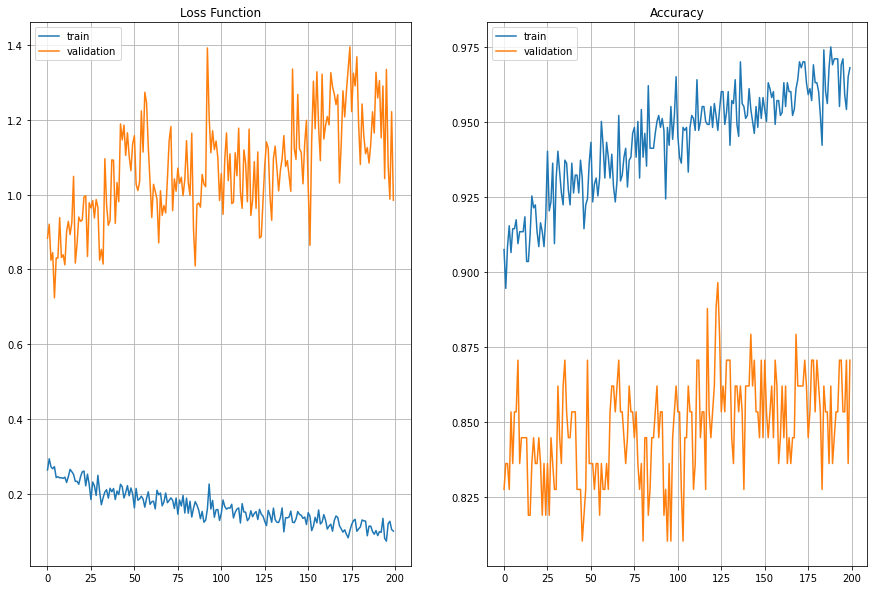

In [56]:
plt.figure(figsize=(15, 10))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss Function')
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.grid(True)
plt.title('Accuracy')
plt.legend()

plt.show()

In [57]:
results = model.evaluate(test_generated, batch_size=1)
print("Test loss, Test accuracy:", results)

 6/23 [======>.......................] - ETA: 6s - loss: 1.6690 - accuracy: 0.8229

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11 bytes but only got 10. Skipping tag 42037
  " Skipping tag %s" % (size, len(data), tag)


23/23 [==============================] - 10s 428ms/step - loss: 1.2546 - accuracy: 0.8164
Test loss, Test accuracy: [1.2546355724334717, 0.8163841962814331]


In [58]:
from sklearn.metrics import classification_report

y_pred = model.predict(test_generated)

y_pred = np.argmax(y_pred, axis=1)

print(classification_report(test_generated.classes, y_pred))

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11 bytes but only got 10. Skipping tag 42037
  " Skipping tag %s" % (size, len(data), tag)


              precision    recall  f1-score   support

           0       0.20      0.19      0.19        73
           1       0.14      0.10      0.12        60
           2       0.31      0.31      0.31        87
           3       0.11      0.15      0.13        52
           4       0.27      0.26      0.26        82

    accuracy                           0.21       354
   macro avg       0.20      0.20      0.20       354
weighted avg       0.22      0.21      0.21       354



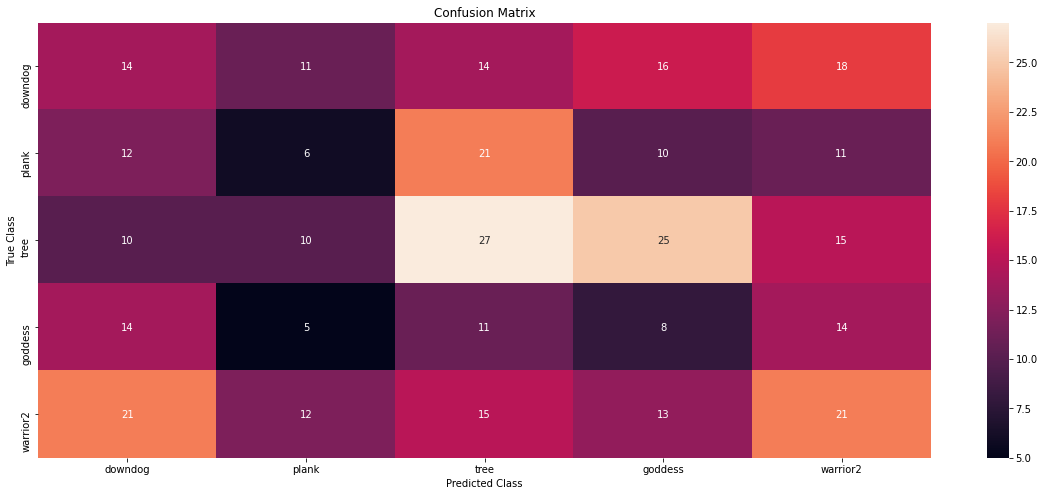

In [59]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

m = confusion_matrix(test_generated.classes, y_pred)

labels = names_classes
plt.figure(figsize=(20, 8))

heatmap = sns.heatmap(m, xticklabels=labels, yticklabels=labels, annot=True, fmt='d')

plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

[1. 0. 0. 0. 0.]


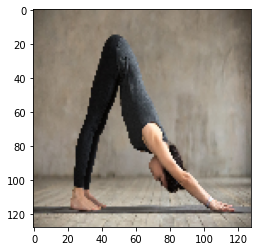

In [60]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

results = []
images = [] 

for x in os.listdir(test_path):
    count = 0
    for image_path in os.listdir(test_path + x + '/'):
       
        images.append(test_path + x + '/' + image_path)
        
        results.append(x)
        count += 1 
        if count == 2:
            break 


image = load_img(images[0], target_size=(128, 128))

input_arr = img_to_array(image)

input_arr = np.array([input_arr])  

prediction = model.predict(input_arr)

print(np.squeeze(prediction))
plt.imshow(image)

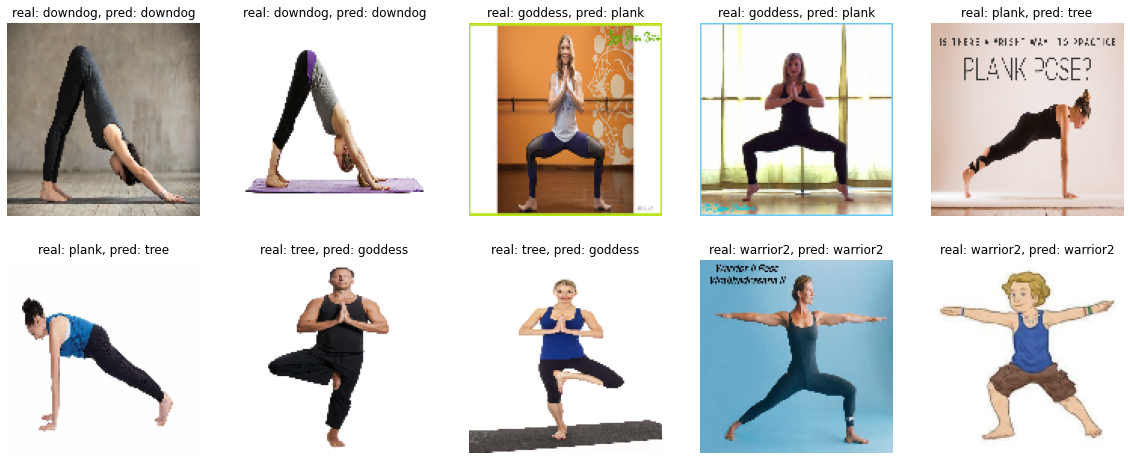

In [61]:
def list_to_label(ls):
    lis = np.squeeze(ls) 
    lis = list(lis)
    index = lis.index(1)
    return names_classes[index]

def read_image(path, size=128):
   
    image = load_img(path, target_size=(size, size))
   
    input_arr = img_to_array(image)
   
    input_arr = np.array([input_arr])  
    
    return image, input_arr
    

plt.figure(figsize=(20,8))

for img_path, ans, i in zip(images, results, np.arange(10)):
    img, arr = read_image(img_path) 
    pred = model.predict(arr)
    plt.subplot(2,5,i+1) 
    plt.imshow(img) 
 
    plt.title(f'real: {ans}, pred: {list_to_label(pred)}')
    plt.axis('off')

plt.show()


In [62]:
model.save('Yoga-Pose-Classifier-CNN-kerastuner.h5')

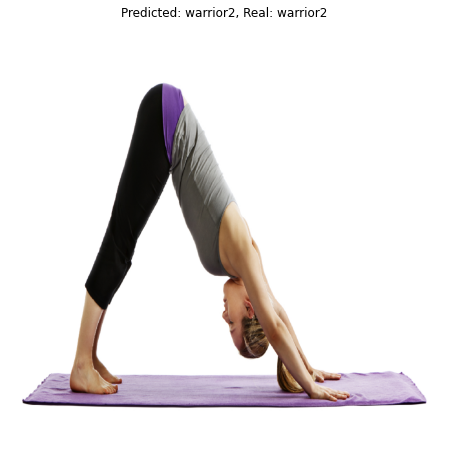

In [63]:
loaded_model = keras.models.load_model('./Yoga-Pose-Classifier-CNN-kerastuner.h5')

img, arr = read_image(images[0])

hd_image, nothing = read_image(images[1], size=1024)

plt.figure(figsize=(8,8))
plt.imshow(hd_image)
plt.title(f'Predicted: {list_to_label(pred)}, Real: {ans}')
plt.axis('off')
plt.show()

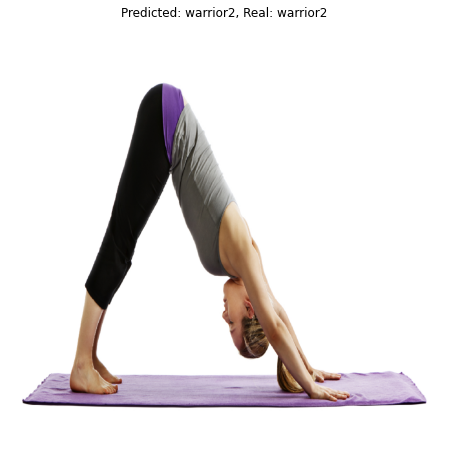

In [64]:
loaded_model = keras.models.load_model('./Yoga-Pose-Classifier-CNN.h5')

img, arr = read_image(images[1])

hd_image, nothing = read_image(images[1], size=1024)

plt.figure(figsize=(8,8))
plt.imshow(hd_image)
plt.title(f'Predicted: {list_to_label(pred)}, Real: {ans}')
plt.axis('off')
plt.show()